In [2]:
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from utils.data import read_csv, data_filter,get_belief_map
from utils.constants import *
import os
import numpy as np
import pandas as pd
from skimage import io
# from transform import Rescale, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, RandomRotation
from utils.vis import show_arrow_batch, show_image_batch
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import PlanktonDataset

In [3]:
img_dir = '/data5/Plankton_wi18/rawcolor_db2/images'
csv_filename = '/data3/ludi/plankton_wi17/pose/poseprediction_torch/data/pose_class/data_train_1.csv'

In [4]:
def randomAngle(a,b):
    return np.random.rand((1))*(b - a) + a

In [5]:
class RandomRotation():
    def __init__(self,angleFx,params):
        self.angleFx = angleFx
        self.params = params
        
    def __call__(self, sample):
        image, coordinates, target_map = sample['image'], sample['coordinates'], sample['target_map']
        x_axis = np.array([1,0])
        
        h = image.shape[0]
        w = image.shape[1]
    
        head = np.array((int(coordinates[0] * w), int(coordinates[1] * h)))
        tail = np.array((int(coordinates[2] * w), int(coordinates[3] * h)))
        
        pose = np.array([head[0] - tail[0],head[1] - tail[1]])
        dot = np.dot(x_axis,pose)
        norm = np.linalg.norm(pose,axis=0)
        
        if norm == 0:
            #Skip this sample
            print()
        
        angle = np.arccos(np.divide(dot,norm))
        
        if pose[1] < 0:
            angle = 2*np.pi - angle
        
        desired_ang = self.angleFx(*self.params)
        rotation_ang = desired_ang - angle
        center = np.vstack(((head[0] + tail[0])/2,(head[1] + tail[1])/2))
        
        M = cv2.getRotationMatrix2D((center[0],center[1]),np.rad2deg(-rotation_ang),1)
        bounds = np.array([[0,0,1],[w,0,1],[0,h,1],[w,h,1]]).T
        bounds_rot = M.dot(bounds)
        min_x = min(bounds_rot[0,:])
        max_x = max(bounds_rot[0,:])
        min_y = min(bounds_rot[1,:])
        max_y = max(bounds_rot[1,:])    

        h_new = max_y - min_y
        w_new = max_x - min_x
        tx = np.abs(np.min([min_x,0]))
        ty = np.abs(np.min([min_y,0]))

        tx -= np.abs(w_new - np.max([max_x,w_new]))
        ty -= np.abs(h_new - np.max([max_y,h_new]))

        bounds_rot = bounds_rot + [[tx],[ty]]
        cosM = np.abs(M[0, 0])
        sinM = np.abs(M[0, 1])

        M[0, 2] += tx
        M[1, 2] += ty
        
        dst = cv2.warpAffine(image,M,(int(np.ceil(w_new)),int(np.ceil(h_new))))
        
        head_rot = M.dot(np.vstack((head.reshape((2,1)),[1])))
        tail_rot = M.dot(np.vstack((tail.reshape((2,1)),[1])))
        corrdinates_rot = [head_rot[0][0]/float(dst.shape[1]),head_rot[1][0]/float(dst.shape[0]),tail_rot[0][0]/float(dst.shape[1]),tail_rot[1][0]/float(dst.shape[0])]
        
        image = dst
        coordinates = corrdinates_rot
        target_map = get_belief_map(coordinates, target_map.shape , 1., 3.)

        copy = {key: sample[key] for key in sample}
        copy['image'], copy['coordinates'], copy['target_map'] = image, coordinates, target_map

        return copys

In [8]:
transformed_dataset = PlanktonDataset(csv_file=csv_filename,
                                      img_dir=img_dir,
                                      transform=transforms.Compose([
                                          RandomRotation()
                                      ]))

In [9]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

In [10]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['coordinates'].size(),
          sample_batched['target_map'].size(),
          sample_batched['cls'])

    if i_batch == 3:
        plt.figure()
        show_arrow_batch(sample_batched)
        plt.figure()
        show_image_batch(sample_batched['target_map'])
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

RuntimeError: Traceback (most recent call last):
  File "/home/zzuberi/zzuberi/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/zzuberi/zzuberi/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 132, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/home/zzuberi/zzuberi/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 132, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/home/zzuberi/zzuberi/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 121, in default_collate
    return torch.stack([torch.from_numpy(b) for b in batch], 0)
  File "/home/zzuberi/zzuberi/lib/python2.7/site-packages/torch/functional.py", line 64, in stack
    return torch.cat(inputs, dim)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 193 and 277 in dimension 1 at /pytorch/torch/lib/TH/generic/THTensorMath.c:2897


In [11]:
for data in dataloader:
    inputs, target_class, target_map, coordinates = \
        data['image'], data['class_index'], data['target_map'], data['coordinates']
    print(target_class)
    break

RuntimeError: Traceback (most recent call last):
  File "/home/zzuberi/zzuberi/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/zzuberi/zzuberi/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 132, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/home/zzuberi/zzuberi/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 132, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/home/zzuberi/zzuberi/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 121, in default_collate
    return torch.stack([torch.from_numpy(b) for b in batch], 0)
  File "/home/zzuberi/zzuberi/lib/python2.7/site-packages/torch/functional.py", line 64, in stack
    return torch.cat(inputs, dim)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 294 and 153 in dimension 1 at /pytorch/torch/lib/TH/generic/THTensorMath.c:2897


In [6]:
%matplotlib inline
def show_arrow(image, coordinates, cls):
    if isinstance(image, (np.ndarray, list)):
        image = np.copy(image)
    elif isinstance(image, torch.FloatTensor):
        image = (image.numpy()).transpose((1, 2, 0)).copy()

    if isinstance(coordinates, torch.FloatTensor):
        coordinates = coordinates.numpy()

    height, width = image.shape[:2]
    head = (int(coordinates[0] * width), int(coordinates[1] * height))
    tail = (int(coordinates[2] * width), int(coordinates[3] * height))
    cv2.arrowedLine(image, tail, head, (1., 0., 0.), 3)
    plt.imshow(image)
    plt.axis('off')
    plt.title(cls)
    plt.pause(0.001)

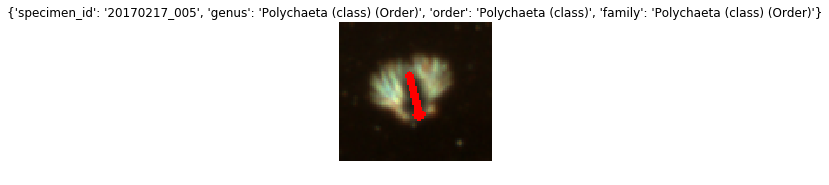

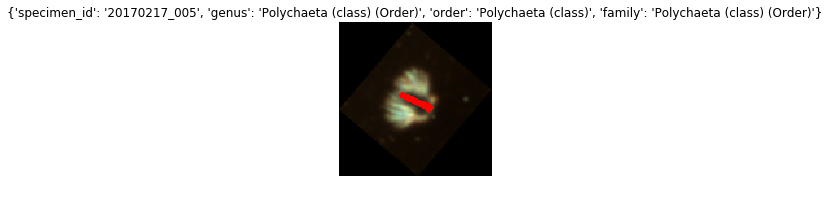

In [10]:
def test(sample, tsfms):
    original = EmptyTransform()

    n = len(tsfms) + 1
    r = int(np.sqrt(n))
    c = np.ceil(1.0 * n / r)

    for i, tsfm in enumerate([original] + tsfms):
        transformed_sample = tsfm(sample)

        ax = plt.subplot(r, c, i + 1)
        show_arrow(transformed_sample['image'], transformed_sample['coordinates'], transformed_sample['cls'])
        ax.set_title(type(tsfm).__name__)
img_dir = '/data5/Plankton_wi18/rawcolor_db2/images'
csv_filename = '/data5/lekevin/plankton/poseprediction/poseprediction_torch/data/4/data_train_0.csv'
plankton_dataset = PlanktonDataset(csv_file=csv_filename,
                                   img_dir=img_dir)

# print(plankton_dataset.__dict__)
scale = Rescale((224, 224))
hflip = RandomHorizontalFlip()
vflip = RandomVerticalFlip()
rotate = RandomRotation(randomAngle,[0,2*np.pi])
composed = transforms.Compose([hflip, vflip,rotate, Rescale((224, 224))])
# print(composed)
plt.close('all')
plt.figure()
test(plankton_dataset[3], [rotate])

plt.show()

In [7]:
import cv2
import torch
import numpy as np

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = cv2.resize(image, (new_w, new_h))

        copy = {key: sample[key] for key in sample}
        copy['image'] = image

        return copy


class ToTensor(object):
    def __call__(self, sample):
        image_name, image, coordinates, cls, class_index, target_map = \
            sample['image_name'], sample['image'], sample['coordinates'], sample['cls'], sample['class_index'], sample['target_map']

        image = image.transpose((2, 0, 1))

        return {'image_name': image_name,
                'image': torch.from_numpy(image),
                'coordinates': torch.from_numpy(coordinates),
                'cls': cls,
                'class_index': class_index,
                'target_map': torch.from_numpy(target_map)}


class RandomHorizontalFlip(object):
    def __call__(self, sample, flip_prob=0.5):
        image, coordinates, target_map = sample['image'], sample['coordinates'], sample['target_map']

        if np.random.rand() < flip_prob:
            image = image[:, ::-1, :].copy()
            coordinates = np.asarray([
                1 - coordinates[0], coordinates[1],
                1 - coordinates[2], coordinates[3]])
            target_map = target_map[:, :, ::-1].copy()

        copy = {key: sample[key] for key in sample}
        copy['image'], copy['coordinates'], copy['target_map'] = image, coordinates, target_map

        return copy


class RandomVerticalFlip(object):
    def __call__(self, sample, flip_prob=0.5):
        image, coordinates, target_map = sample['image'], sample['coordinates'], sample['target_map']

        if np.random.rand() < flip_prob:
            image = image[::-1, :, :].copy()
            coordinates = np.asarray([
                coordinates[0], 1 - coordinates[1],
                coordinates[2], 1 - coordinates[3]])
            target_map = target_map[:, ::-1, :].copy()

        copy = {key: sample[key] for key in sample}
        copy['image'], copy['coordinates'], copy['target_map'] = image, coordinates, target_map

        return copy


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.

        Returns:
            Tensor: Normalized image.
        """
        image = sample['image']

        for t, m, s in zip(image, self.mean, self.std):
            t.sub_(m).div_(s)

        copy = {key: sample[key] for key in sample}
        copy['image'] = image

        return copy

    def recover(self, sample):
        image = sample['image'].clone()

        for t, m, s in zip(image, self.mean, self.std):
            t.add_(m).mul_(s)

        copy = {key: sample[key] for key in sample}
        copy['image'] = image

        return copy


class EmptyTransform(object):
    def __call__(self, sample):
        return sample


